<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importations-et-fonctions" data-toc-modified-id="Importations-et-fonctions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importations et fonctions</a></span></li><li><span><a href="#Sélections-de-variables" data-toc-modified-id="Sélections-de-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sélections de variables</a></span><ul class="toc-item"><li><span><a href="#Variables-quantitatives" data-toc-modified-id="Variables-quantitatives-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Variables quantitatives</a></span></li><li><span><a href="#Variables-qualitatives" data-toc-modified-id="Variables-qualitatives-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Variables qualitatives</a></span></li><li><span><a href="#Data-leakage" data-toc-modified-id="Data-leakage-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Data leakage</a></span></li></ul></li><li><span><a href="#EDA-et-traitements" data-toc-modified-id="EDA-et-traitements-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA et traitements</a></span><ul class="toc-item"><li><span><a href="#Variables-quantitatives" data-toc-modified-id="Variables-quantitatives-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Variables quantitatives</a></span></li><li><span><a href="#Variables-qualitatives" data-toc-modified-id="Variables-qualitatives-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Variables qualitatives</a></span></li></ul></li><li><span><a href="#Variables-cibles" data-toc-modified-id="Variables-cibles-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Variables cibles</a></span></li><li><span><a href="#Modèles-prédictifs" data-toc-modified-id="Modèles-prédictifs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modèles prédictifs</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Régressions-linéaires" data-toc-modified-id="Régressions-linéaires-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Régressions linéaires</a></span></li><li><span><a href="#Réseaux-de-neurones" data-toc-modified-id="Réseaux-de-neurones-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Réseaux de neurones</a></span></li><li><span><a href="#Modèles-ensemblistes" data-toc-modified-id="Modèles-ensemblistes-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Modèles ensemblistes</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-5.4.3"><span class="toc-item-num">5.4.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#GMM" data-toc-modified-id="GMM-5.4.4"><span class="toc-item-num">5.4.4&nbsp;&nbsp;</span>GMM</a></span></li></ul></li><li><span><a href="#Analyse-d'erreurs" data-toc-modified-id="Analyse-d'erreurs-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Analyse d'erreurs</a></span><ul class="toc-item"><li><span><a href="#Energie" data-toc-modified-id="Energie-5.5.1"><span class="toc-item-num">5.5.1&nbsp;&nbsp;</span>Energie</a></span></li><li><span><a href="#Emission-GHG" data-toc-modified-id="Emission-GHG-5.5.2"><span class="toc-item-num">5.5.2&nbsp;&nbsp;</span>Emission GHG</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

Le but de ce notebook est de prédire la consommation d'énergie et l'émission de gaz à effet de serre de bâtiments non habitable du jeu de données présent [ici](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv).

Pour cela, des EDA sont effectuées pour employer les traitements nécessaires.
Les variables représente les caractéristiques des bâtiments (nombre d'étages, consommation de gaz, type de fonction employé, surface, localisation, etc.)

Différents modèles sont employés avec des recherches d'hyperparamètres (Random Search et Bayesian Optimisation):
- Régressions linéaires (Lasso, Ridge, ElasticNet)
- Réseaux de neurones
- Random Forest
- XGBoost
- CatBoost
- GMM (pour traiter les localitions)

Une analyse d'erreur est également présente pour observer les prédictions.

# Importations et fonctions

In [ ]:
!pip install scikit-optimize
!pip install catboost

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import tensorflow as tf
import random

from scipy import stats
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

In [ ]:
def print_histogram(df_hist, list_var, nrow, ncol, mes=""):
    """
    Affiche un groupe d'histogramme
    :param: df_hist: le jeu de données utilisé pour les histogrammes
    :param: list_var: la liste des variables du dataframe que nous voulons afficher
    :param: nrow: le nombre d'histogrammes par ligne
    :param: ncol: le nombre d'histogrammes par colonne
    :param: mes: le message utilisé pour le titre de chaque histogramme
    """
    fig = plt.figure(figsize=(12, 8))

    for index, var in enumerate(list_var):
        ax=fig.add_subplot(nrow,ncol,index+1)
        df_hist[var].hist(ax=ax)
        ax.set_title("{}{}".format(mes, var))
    fig.tight_layout()
    plt.show()

def print_boxplot(df_box, list_var, x_var, nrow, ncol, mes="", outliers=True):
    """
    Affiche un groupe de boîte à moustache
    :param: df_box: le jeu de données utilisé pour les bôites à moustache
    :param: list_var: la liste des variables du dataframe que nous voulons afficher
    :param: nrow: le nombre d'histogrammes par ligne
    :param: ncol: le nombre d'histogrammes par colonne
    :param: mes: le message utilisé pour le titre de chaque histogramme
    :param: outliers: prendre en compte les valeurs aberrantes ou non
    """
    fig = plt.figure(figsize=(12, 8))

    for index, var in enumerate(list_var):
        ax=fig.add_subplot(nrow,ncol,index+1)
        df_box.boxplot(column=x_var, by=var, ax=ax, rot=90, showfliers=outliers)
        ax.set_title("{}{}".format(mes, var))
    fig.tight_layout()
    fig.suptitle('')
    plt.show()

def print_scatter_plot(df, list_var, x_var, nrow, ncol, mes=""):
    """
    Affiche un groupe de nuage de points
    :param: df: le jeu de données utilisé pour les bôites à moustache
    :param: list_var: la liste des variables du dataframe que nous voulons afficher
    :param: nrow: le nombre plot par ligne
    :param: ncol: le nombre plot par colonne
    :param: mes: le message utilisé pour le titre de chaque histogramme
    """
    fig = plt.figure(figsize=(20, 15))

    for index, var in enumerate(list_var):
        ax=fig.add_subplot(nrow, ncol, index+1)
        df_2016.plot.scatter(x=var, y=x_var, ax=ax)
        ax.set_title("{}{}".format(mes, var))
    fig.tight_layout()
    plt.show()
  

def keep_categorical_value(df, var, limit):
  """
  Retourne la liste des modalités à conserver en fonction de la limite
  :param: df: le dataframe
  :param: var: la variable à explorer
  :param: limit: la limite à conserver
  """
    
  index = 0
  sum_freq = 0

  for i in df[var].value_counts(normalize=True).values:
    sum_freq += i
    index += 1
    if sum_freq > limit:
      break

  return df[var].value_counts().index[:index]

def random_search_nn(X_train, y_train, X_test, y_test, n_iter):
  """
  Random search sur des réseaux de neurones
  """

  best_scores = [[999, 999, 999] for x in range(2)]
  activations = ['linear', 'sigmoid', 'relu']
  for cpt in range(n_iter):
    print("Itération n°", cpt + 1)
    list_layers = [tf.keras.Input(shape=(X_train.shape[1],))]

    list_pow_dense = []
    for i in range(random.randint(0, 2)):
      power2 = random.randint(2, 4)
      power = np.power(2, power2)
      activation = activations[random.randint(0, 2)]
      list_pow_dense.append((power, round(0.05*(power2+1),2), activation))
      list_layers.append(tf.keras.layers.Dense(power, activation=activation,
                                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1)))
      list_layers.append(tf.keras.layers.Dropout(0.05*(power2+1)))

    list_layers.append(tf.keras.layers.Dense(1, 
                                            kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1)))

    lr = 10**random.uniform(np.log10(1e-3), np.log10(1e-1))
    nb_batch = np.power(2, random.randint(2, 4))

    print("List dense : {}, Learning rate : {}, Batch : {}".format(list_pow_dense, lr, nb_batch))

    model = tf.keras.Sequential(list_layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    model.fit(X_train, y_train, epochs=100, 
              batch_size=nb_batch,
              verbose=0,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

    rmse_train = mean_squared_error(model.predict(X_train), y_train)
    rmse_test = mean_squared_error(model.predict(X_test), y_test)
    print('Train : {}, Test : {}'.format(rmse_train, rmse_test))
    
    if rmse_train < best_scores[0][1]:
      best_scores[0][0] = (list_pow_dense, lr, nb_batch)
      best_scores[0][1] = rmse_train
      best_scores[0][2] = rmse_test
    if rmse_test < best_scores[1][2]:
      best_scores[1][0] = (list_pow_dense, lr, nb_batch)
      best_scores[1][1] = rmse_train
      best_scores[1][2] = rmse_test

    print("-----------")

  print("Meilleur taux de succès train :")
  print("Combinaison : {}, Train : {}, Test : {}".format(best_scores[0][0], best_scores[0][1], best_scores[0][2]))
  print("Meilleur taux de succès test :")
  print("Combinaison : {}, Train : {}, Test : {}".format(best_scores[1][0], best_scores[1][1], best_scores[1][2]))

def get_train_test(df, features, catboost_flag=False, index=0):
  """
  Retourne les jeux d'entraînements et de tests
  """

  df['ENERGYSTARScore'] = df['ENERGYSTARScore'].fillna(df['ENERGYSTARScore'].mean())
  df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(df['LargestPropertyUseTypeGFA'].mean())

  X_SEU_train, X_SEU_test, y_SEU_train, y_SEU_test = model_selection.train_test_split(df[features], 
                                                                                      df['SiteEnergyUse(kBtu)'], 
                                                                                      test_size=0.3,
                                                                                      random_state=1)

  X_TGE_train, X_TGE_test, y_TGE_train, y_TGE_test = model_selection.train_test_split(df[features], 
                                                                                      df['TotalGHGEmissions'], 
                                                                                      test_size=0.3,
                                                                                      random_state=1)
  
  std_scale_SEU = preprocessing.StandardScaler().fit(X_SEU_train.iloc[:, index:])
  X_SEU_train_std = std_scale_SEU.transform(X_SEU_train.iloc[:, index:])
  X_SEU_test_std = std_scale_SEU.transform(X_SEU_test.iloc[:, index:])

  std_scale_TGE = preprocessing.StandardScaler().fit(X_TGE_train.iloc[:, index:])
  X_TGE_train_std = std_scale_TGE.transform(X_TGE_train.iloc[:, index:])
  X_TGE_test_std = std_scale_TGE.transform(X_TGE_test.iloc[:, index:])

  if catboost_flag:
    X_SEU_train.iloc[:, index:] = X_SEU_train_std
    X_SEU_test.iloc[:, index:] = X_SEU_test_std
    X_SEU_train_std = X_SEU_train
    X_SEU_test_std = X_SEU_test

    X_TGE_train.iloc[:, index:] = X_TGE_train_std
    X_TGE_test.iloc[:, index:] = X_TGE_test_std
    X_TGE_train_std = X_TGE_train
    X_TGE_test_std = X_TGE_test


  return X_SEU_train_std, X_SEU_test_std, X_TGE_train_std, X_TGE_test_std, \
         y_SEU_train, y_SEU_test, y_TGE_train, y_TGE_test

In [ ]:
df_2016 = pd.read_csv('drive/MyDrive/OC/OC/Projet 3/2016-building-energy-benchmarking.csv')
df_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [ ]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

# Sélections de variables

Etant donné que nous allons travailler uniquement sur les bâtiments non habitable, regardons en détail la variable qui donne cette information : 'BuildingType'.

In [ ]:
len_init = len(df_2016)
df_2016 = df_2016[df_2016['BuildingType'] == 'NonResidential']
print("Proportion observations : {:.2f}% soit {} instances".format(len(df_2016)/len_init*100, len(df_2016)))  

Proportion observations : 43.25% soit 1460 instances


1460 bâtiments sont conservés

## Variables quantitatives

In [ ]:
df_2016.select_dtypes(['number']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 3356
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1460 non-null   int64  
 1   DataYear                         1460 non-null   int64  
 2   ZipCode                          1460 non-null   float64
 3   CouncilDistrictCode              1460 non-null   int64  
 4   Latitude                         1460 non-null   float64
 5   Longitude                        1460 non-null   float64
 6   YearBuilt                        1460 non-null   int64  
 7   NumberofBuildings                1458 non-null   float64
 8   NumberofFloors                   1460 non-null   int64  
 9   PropertyGFATotal                 1460 non-null   int64  
 10  PropertyGFAParking               1460 non-null   int64  
 11  PropertyGFABuilding(s)           1460 non-null   int64  
 12  LargestPropertyUseTy

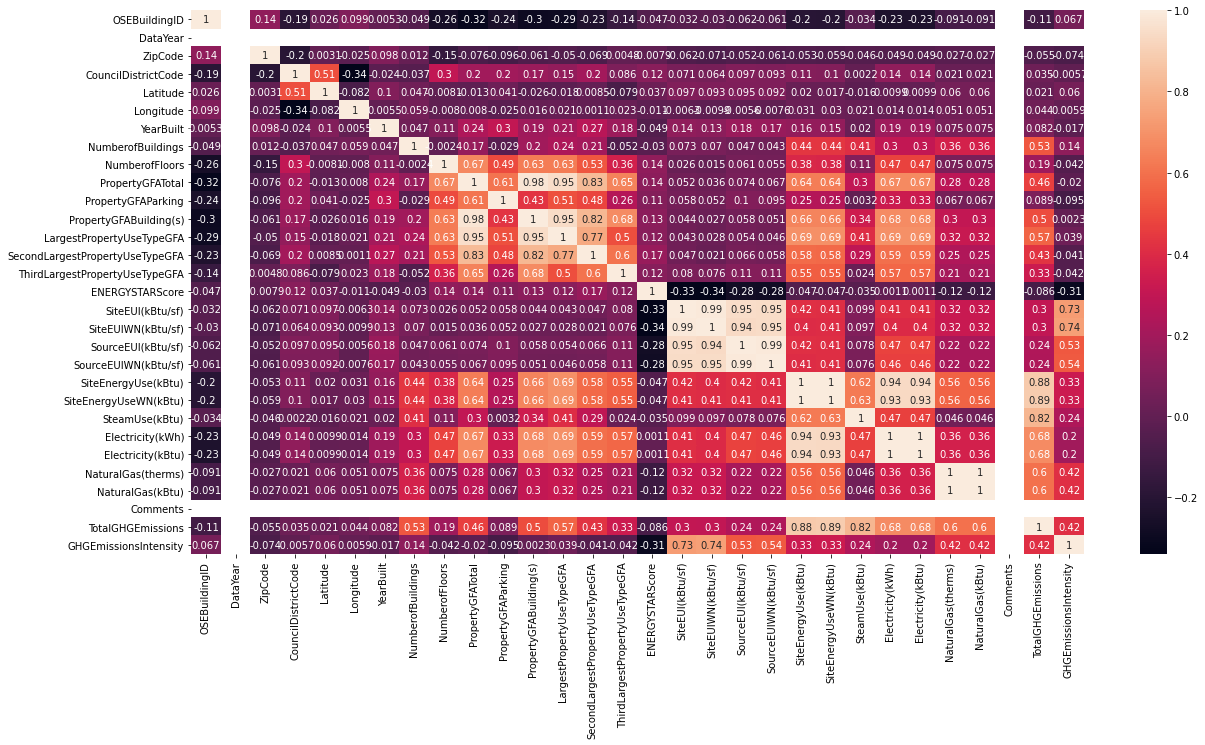

In [ ]:
correlation_matrix = df_2016.select_dtypes(['number']).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, annot=True)

Nous observons de fortes corrélations entre certaines variables telles que "PropertyGFABuildings" avec "PropertyGFATotal" étant donné que cette dernière est la somme de plusieurs variables dont celle la précédent.

Nous allons donc supprimer certaines de ces variables et également celles correspondant à de simples conversations d'unités, apportant donc que des informations redondantes.

Les variables avec beaucoup de données manquantes ne sont pas retenue (excepté "ENERGYSTARScore"), de même pour "DataYear" qui correspond à l'année du dataset soit 2016.

In [ ]:
col_del_numeric = ['OSEBuildingID', 'ZipCode', 'CouncilDistrictCode', 'PropertyGFATotal', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                   'SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)', 'Comments', 'DataYear',
                   'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']

## Variables qualitatives

In [ ]:
df_2016.select_dtypes(['object']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 3356
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   BuildingType                   1460 non-null   object
 1   PrimaryPropertyType            1460 non-null   object
 2   PropertyName                   1460 non-null   object
 3   Address                        1460 non-null   object
 4   City                           1460 non-null   object
 5   State                          1460 non-null   object
 6   TaxParcelIdentificationNumber  1460 non-null   object
 7   Neighborhood                   1460 non-null   object
 8   ListOfAllPropertyUseTypes      1458 non-null   object
 9   LargestPropertyUseType         1454 non-null   object
 10  SecondLargestPropertyUseType   796 non-null    object
 11  ThirdLargestPropertyUseType    315 non-null    object
 12  YearsENERGYSTARCertified       90 non-null     object
 13  Com

Plusieurs variables indiquent la localisation ou le type d'utilisation donc nous pouvons en éliminer.

Nous n'allons pas conserver celles qui possèdent beaucoup de valeurs manquantes et les identifiants.

In [ ]:
col_del_categorical = ['PropertyName', 'Address', 'State', 'City', 'TaxParcelIdentificationNumber', 'BuildingType',
                       'ListOfAllPropertyUseTypes', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
                       'YearsENERGYSTARCertified', 'Outlier']

df_2016 = df_2016.drop(col_del_numeric + col_del_categorical, axis=1)

## Data leakage

En lisant la [documentation](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy) du jeu de données, plusieurs variables peuvent être associées à la fuite de données et donc ne peuvent être gardées ou employées sans transformation.

Nous pouvons également éliminer les variables n'apportant pas d'informations intéressantes.

In [ ]:
col_data_leakage = ['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity', 'DefaultData', 'ComplianceStatus']
df_2016 = df_2016.drop(col_data_leakage, axis=1)

# EDA et traitements

Les instances avec la variable cible "SiteEnergyUse(kBtu)" ayant une valeur nulle sont supprimées.

In [ ]:
df_2016 = df_2016[df_2016['SiteEnergyUse(kBtu)'].notna()]

## Variables quantitatives

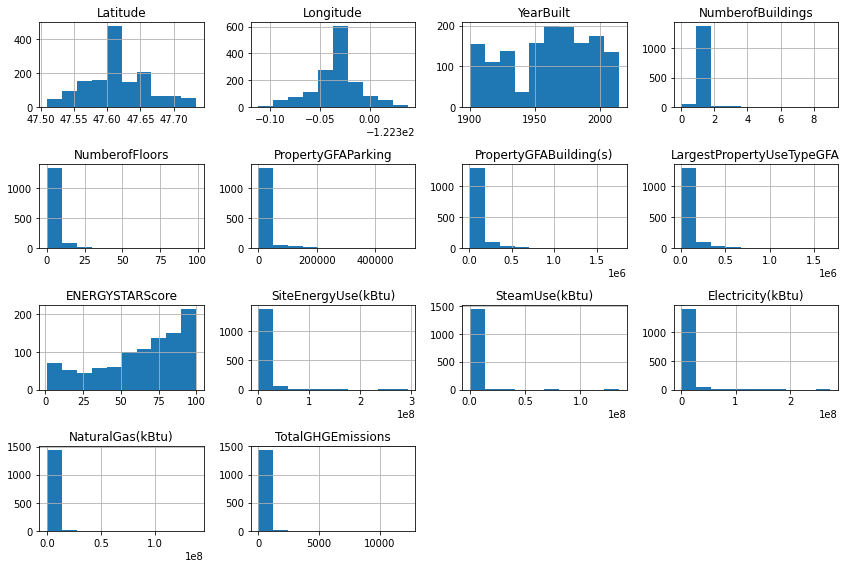

In [ ]:
print_histogram(df_2016, df_2016.select_dtypes(['number']).columns, 4, 4)

Ces histogrammes montrent que la plupart des variables possèdent des valeurs extrêmes.

Cela peut être vérifié en regardant les quantiles, les moyennes, valeurs maximales, etc..

In [ ]:
df_2016.select_dtypes(['number']).describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1.458000e+03,1.454000e+03,995.000000,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1458.000000
mean,47.616092,-122.333471,1960.891632,1.034294,4.372428,14274.941701,9.885983e+04,9.124103e+04,63.862312,7.743262e+06,4.998068e+05,5.514732e+06,1.681726e+06,166.340947
std,0.046632,0.023020,32.963561,0.540904,6.768085,44417.899792,1.689776e+05,1.562497e+05,28.917564,1.909175e+07,5.448602e+06,1.329224e+07,5.646165e+06,586.106337
min,47.509590,-122.411820,1900.000000,0.000000,0.000000,0.000000,3.636000e+03,5.656000e+03,1.000000,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,-0.800000
25%,47.587825,-122.342405,1929.000000,1.000000,1.000000,0.000000,2.818200e+04,2.521550e+04,44.000000,1.201677e+06,0.000000e+00,7.042265e+05,0.000000e+00,18.912500
50%,47.612420,-122.333210,1965.000000,1.000000,3.000000,0.000000,4.591200e+04,4.166800e+04,71.000000,2.598999e+06,0.000000e+00,1.658950e+06,4.187330e+05,47.055000
75%,47.648785,-122.322882,1988.000000,1.000000,5.000000,0.000000,9.389075e+04,8.978975e+04,89.000000,6.950048e+06,0.000000e+00,5.076646e+06,1.380787e+06,133.560000
max,47.733870,-122.261800,2015.000000,9.000000,99.000000,512608.000000,1.765970e+06,1.680937e+06,100.000000,2.930908e+08,1.349435e+08,2.745325e+08,1.381912e+08,12307.160000


YearBuilt peut être converti en année d'ancienneté afin de considérer cette variable comme étant quantitative.

Nous rajoutons une année à l'année la plus récente pour la transformation en log employée plus loin dans le notebook.

In [ ]:
df_2016['YearBuilt'] = (max(df_2016['YearBuilt']) + 1) - df_2016['YearBuilt']

Concernant les variables indiquant la consommation d'énergie avec le gaz, la vapeur ou électricité, nous allons les transformer en pourcentage d'utilisation afin d'éviter le data leakage.

Pour la construction de nouveaux bâtiments, l'utilisateur pourra saisir les pourcentages d'utilisation des types d'énergie qui seront potentiellement utilisés.

Assurons-nous d'abord que "SiteEnergyUse(kBtu)" est bien la somme des variables représentant les types d'énergie.


In [ ]:
df_energy = pd.DataFrame()
df_energy['total_energy'] = df_2016['Electricity(kBtu)'] + df_2016['NaturalGas(kBtu)'] + df_2016['SteamUse(kBtu)']
df_energy['SiteEnergyUse'] = df_2016['SiteEnergyUse(kBtu)']
df_energy['Difference'] = abs(df_energy['SiteEnergyUse'] - df_energy['total_energy'])
df_energy['Pourcentage'] = df_energy['Difference']/df_energy['SiteEnergyUse']*100
df_energy.head()

,total_energy,SiteEnergyUse,Difference,Pourcentage
0,7226362.00,7226362.5,0.50,0.000007
1,8387933.00,8387933.0,0.00,0.000000
2,72587018.00,72587024.0,6.00,0.000008
3,6794583.25,6794584.0,0.75,0.000011
4,14172605.00,14172606.0,1.00,0.000007


In [ ]:
df_energy[df_energy['Pourcentage'] >= 1]

,total_energy,SiteEnergyUse,Difference,Pourcentage
206,41377888.0,4.084775e+07,5.301360e+05,1.297834
403,7877393.0,9.058916e+06,1.181523e+06,13.042653
448,1951818.0,1.119592e+07,9.244099e+06,82.566698
513,0.0,1.252517e+07,1.252517e+07,100.000000
563,6287167.0,5.177270e+06,1.109896e+06,21.437870
601,19295187.0,3.795171e+07,1.865652e+07,49.158581
2037,1815369.0,2.107744e+06,2.923748e+05,13.871456
2441,2589388.0,2.092696e+06,4.966920e+05,23.734551
2761,204995.0,9.772303e+05,7.722353e+05,79.022857
2791,1323792.0,4.729846e+06,3.406054e+06,72.011946


Nous remarquons qu'il y a qu'une douzaine d'invidus et les erreurs proviennent probablement d'une erreur de saisie. Nous n'allons pas les conserver.

Comme la somme des trois variables énergétiques est égale la variable d'énergie totale, nous pouvons conserver uniquement 2 et les transformer en pourcentage.

In [ ]:
df_2016 = df_2016[df_energy['Pourcentage'] < 1]
df_2016 = df_2016.drop(columns ='SteamUse(kBtu)')
df_2016['Electricity(kBtu)'] = df_2016['Electricity(kBtu)'] / df_2016['SiteEnergyUse(kBtu)']
df_2016['NaturalGas(kBtu)'] = df_2016['NaturalGas(kBtu)'] / df_2016['SiteEnergyUse(kBtu)']

In [ ]:
df_2016.select_dtypes(['number']).describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1.442000e+03,1.438000e+03,984.000000,1.442000e+03,1442.000000,1442.000000,1442.000000
mean,47.616005,-122.333497,55.190707,1.032594,4.357836,14286.341886,9.767779e+04,9.028134e+04,63.740854,7.700997e+06,0.710597,0.267964,167.451387
std,0.046608,0.023082,32.884680,0.533062,6.759749,44505.197378,1.652906e+05,1.541798e+05,28.870689,1.911998e+07,0.264589,0.264956,589.185112
min,47.509590,-122.411820,1.000000,0.000000,0.000000,0.000000,3.636000e+03,5.656000e+03,1.000000,1.680890e+04,0.000000,0.000000,0.120000
25%,47.587682,-122.342493,28.000000,1.000000,1.000000,0.000000,2.811325e+04,2.520000e+04,44.000000,1.201677e+06,0.498617,0.000000,19.082500
50%,47.612420,-122.333225,51.000000,1.000000,3.000000,0.000000,4.569000e+04,4.161950e+04,71.000000,2.593203e+06,0.728833,0.215839,47.100000
75%,47.648785,-122.322835,87.000000,1.000000,5.000000,0.000000,9.376725e+04,8.934400e+04,88.250000,6.907070e+06,0.999999,0.481997,133.745000
max,47.733870,-122.261800,116.000000,9.000000,99.000000,512608.000000,1.765970e+06,1.680937e+06,100.000000,2.930908e+08,1.000011,1.000000,12307.160000


Certaines valeurs aberrante ont été retirées.

Cependant certaines localisations possèdent 0 bâtiment.

In [ ]:
df_2016[df_2016["NumberofBuildings"] == 0].head()

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
63,Medical Office,EAST,47.61244,-122.32140,51,0.0,3,0,179014,Medical Office,179014.0,48.0,16701055.00,0.591968,0.408032,430.84
76,Small- and Mid-Sized Office,MAGNOLIA / QUEEN ANNE,47.62391,-122.34837,30,0.0,2,2352,63888,Office,45900.0,NaN,4166306.25,1.000000,0.000000,29.04
160,Warehouse,GREATER DUWAMISH,47.57507,-122.35747,100,0.0,4,0,79600,Non-Refrigerated Warehouse,79600.0,34.0,2411402.25,1.000000,0.000000,16.81
201,Large Office,DOWNTOWN,47.61757,-122.35122,48,0.0,3,26731,74003,Office,100734.0,20.0,9788717.00,1.000000,0.000000,68.24
241,Small- and Mid-Sized Office,NORTHEAST,47.66100,-122.31626,55,0.0,5,0,99005,Office,79555.0,70.0,4728488.50,0.605524,0.394476,119.03


Nous notons que cela est peut-être dû à une mauvaise saisie et donc mettons un palier minimum de 1.

De même pour le nombre d'étages.

In [ ]:
df_2016[['NumberofBuildings', 'NumberofFloors']] = df_2016[['NumberofBuildings', 'NumberofFloors']].clip(1)

Regardons la distribution des valeurs à travers de nuages de points.

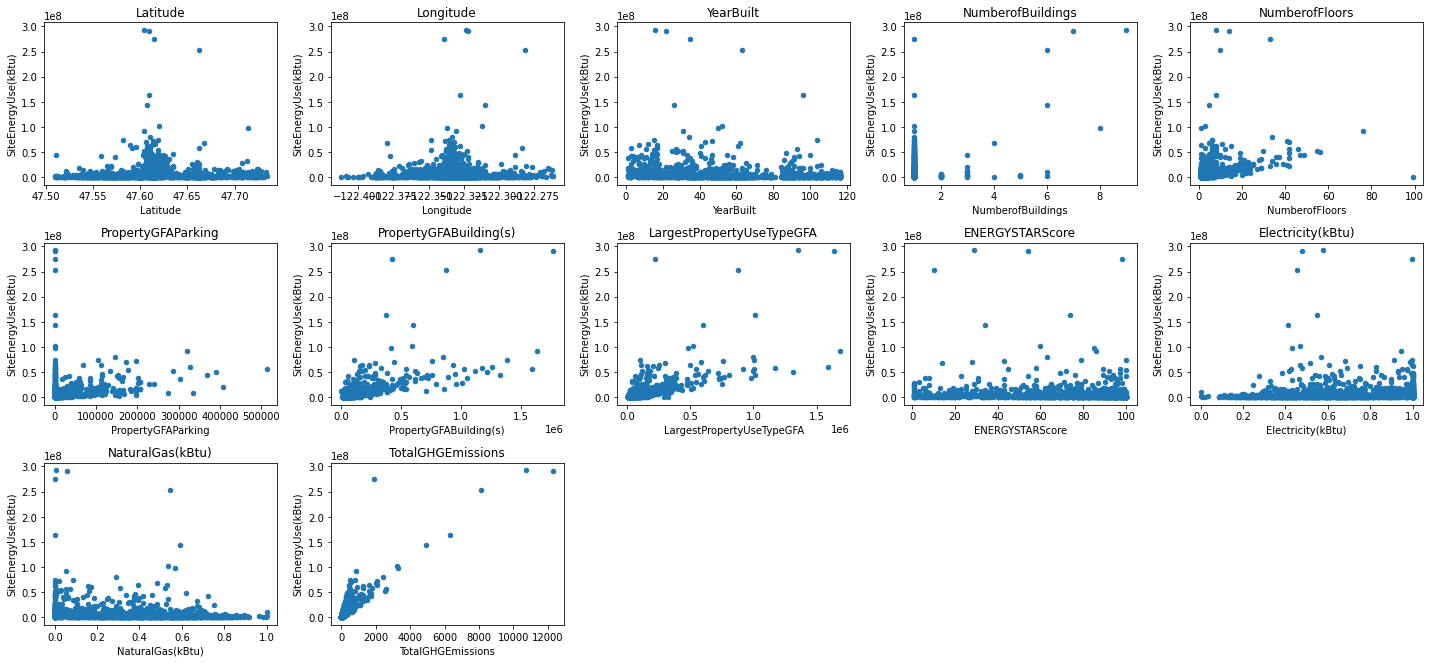

In [ ]:
list_var = [x for x in df_2016.select_dtypes(['number']).columns if x != 'SiteEnergyUse(kBtu)']
print_scatter_plot(df_2016, list_var, 'SiteEnergyUse(kBtu)', 5, 5)

Nous voyons qu'il y a la présence de valeurs extrêmes.

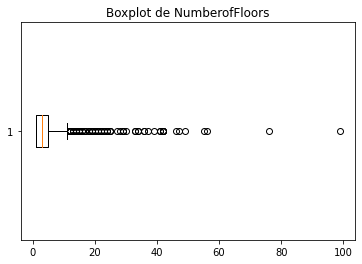

In [ ]:
_, box_buildings = plt.subplots()
box_buildings.set_title('Boxplot de NumberofFloors')
box_buildings.boxplot(df_2016['NumberofFloors'], vert=False);

Une transformation par logarithme est donc utile pour l'entraînement des modèles.

Etant donné que le nombre de bâtiment est souvent égal à 1, 0.5 a été ajouté au minimum pour éviter un nombre conséquent de valeur nulle.

"PropertyGFAParking" a beaucoup de valeur nulle donc une limite minimal de 1 est employée pour une transformation à 0 après le log.

In [ ]:
df_2016[['NumberofBuildings', 'NumberofFloors']] = df_2016[['NumberofBuildings', 'NumberofFloors']].clip(1.5)
df_2016['PropertyGFAParking'] = df_2016['PropertyGFAParking'].clip(1.5)

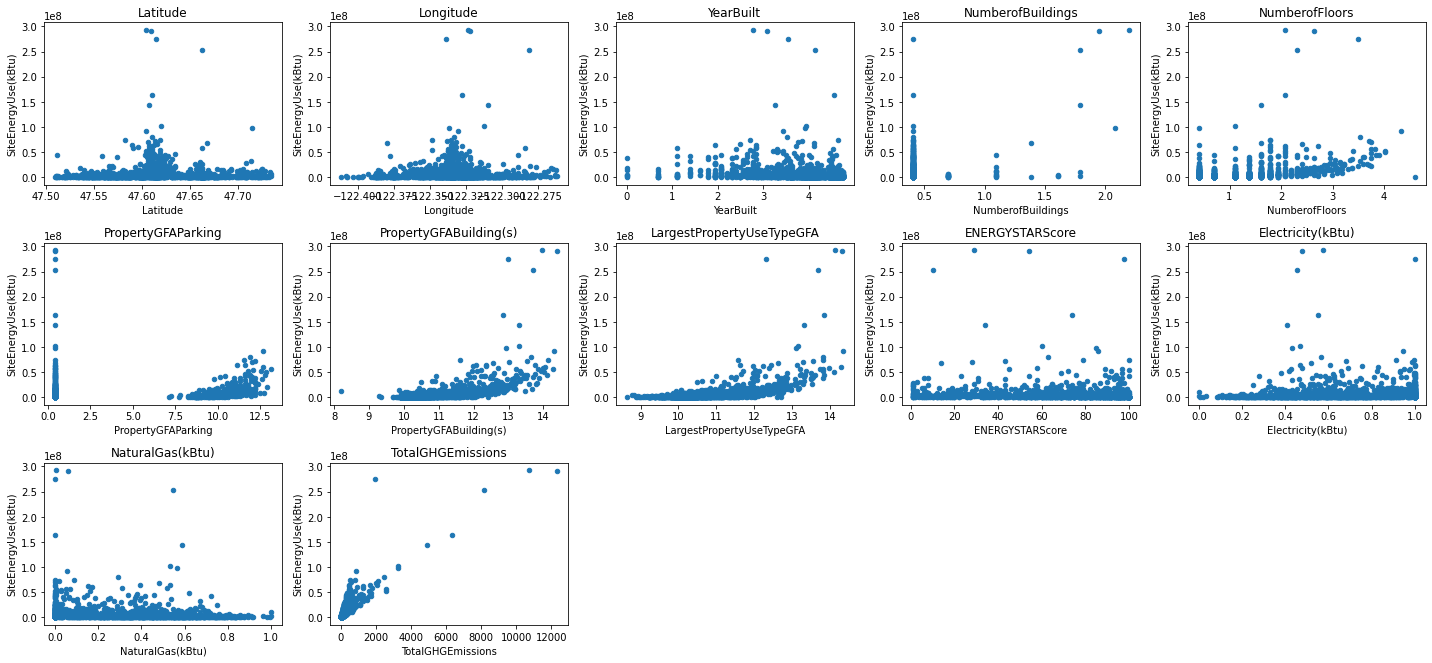

In [ ]:
col_ln = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 
          'LargestPropertyUseTypeGFA']

df_2016[col_ln] = np.log(df_2016[col_ln])  
print_scatter_plot(df_2016, list_var, 'SiteEnergyUse(kBtu)', 5, 5)

Les valeurs sont maintenant mieux proportionées

In [ ]:
df_2016.describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1438.000000,984.000000,1.442000e+03,1442.000000,1442.000000,1442.000000
mean,47.616005,-122.333497,3.743150,0.423848,1.114367,2.633707,10.946909,10.832823,63.740854,7.700997e+06,0.710597,0.267964,167.451387
std,0.046608,0.023082,0.862143,0.138536,0.743197,4.216445,0.891170,0.946210,28.870689,1.911998e+07,0.264589,0.264956,589.185112
min,47.509590,-122.411820,0.000000,0.405465,0.405465,0.405465,8.198639,8.640472,1.000000,1.680890e+04,0.000000,0.000000,0.120000
25%,47.587682,-122.342493,3.332205,0.405465,0.405465,0.405465,10.243996,10.134599,44.000000,1.201677e+06,0.498617,0.000000,19.082500
50%,47.612420,-122.333225,3.931826,0.405465,1.098612,0.405465,10.729635,10.636324,71.000000,2.593203e+06,0.728833,0.215839,47.100000
75%,47.648785,-122.322835,4.465908,0.405465,1.609438,0.405465,11.448571,11.400249,88.250000,6.907070e+06,0.999999,0.481997,133.745000
max,47.733870,-122.261800,4.753590,2.197225,4.595120,13.147267,14.384211,14.334862,100.000000,2.930908e+08,1.000011,1.000000,12307.160000


## Variables qualitatives

In [ ]:
for cat in df_2016.select_dtypes(['object']).columns:
    print("{} : {}".format(cat, len(df_2016[cat].value_counts())))

PrimaryPropertyType : 21
Neighborhood : 18
LargestPropertyUseType : 50


Les 3 variables qualitatives possèdent:
- "PrimaryPropertyType" : 21 modalités
- "Neighborhood" : 18 modalités
- "LargestPropertyUseType" : 50 modalités

In [ ]:
df_2016.select_dtypes(['object']).head()

,PrimaryPropertyType,Neighborhood,LargestPropertyUseType
0,Hotel,DOWNTOWN,Hotel
1,Hotel,DOWNTOWN,Hotel
2,Hotel,DOWNTOWN,Hotel
3,Hotel,DOWNTOWN,Hotel
4,Hotel,DOWNTOWN,Hotel


"PrimaryPropertyType" et "LargestPropertyUseType" semblent être liées.



In [ ]:
crosstab_property = pd.crosstab(df_2016['PrimaryPropertyType'], df_2016['LargestPropertyUseType'])
crosstab_property.head(10)

LargestPropertyUseType,Adult Education,Automobile Dealership,Bank Branch,College/University,Courthouse,Data Center,Distribution Center,Financial Office,Fitness Center/Health Club/Gym,Food Service,Hospital (General Medical & Surgical),Hotel,K-12 School,Laboratory,Lifestyle Center,Manufacturing/Industrial Plant,Medical Office,Movie Theater,Multifamily Housing,Museum,Non-Refrigerated Warehouse,Office,Other,Other - Education,Other - Entertainment/Public Assembly,Other - Lodging/Residential,Other - Mall,Other - Public Services,Other - Recreation,Other - Restaurant/Bar,Other - Services,Other - Utility,Other/Specialty Hospital,Parking,Performing Arts,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Pre-school/Daycare,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Residence Hall/Dormitory,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Wholesale Club/Supercenter,Worship Facility
PrimaryPropertyType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Distribution Center,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hospital,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hotel,0,0,0,0,0,0,0,0,0,0,0,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
K-12 School,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Laboratory,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Large Office,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Low-Rise Multifamily,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Medical Office,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mixed Use Property,0,0,1,0,0,0,1,0,1,0,0,1,0,3,0,0,2,0,9,0,12,27,9,2,3,0,0,0,0,1,0,0,0,13,0,0,0,0,0,1,2,7,0,0,2,1,2,0,0,0


Les valeurs semblent être identiques pour la plupart des instances.

Nous allons confirmer cette dépendance à l'aide d'un test de Chi2.

In [ ]:
stats.chi2_contingency(crosstab_property)[1]

0.0

Le p.value du test de Chi2 est inférieur à 0.05 donc nous pouvons rejeter l'hypothèse nulle et donc affirmer que les deux variables sont corrélées. Ainsi, nous n'allons pas prendre en compte "LargestPropertyUseType" qui possède le plus de modalités.

In [ ]:
df_2016 = df_2016.drop("LargestPropertyUseType", axis=1)

Les variables qualitatives ont un nombre de modalités conséquent. Il est donc nécessaire de les réduire en conservant les modalités représentant 80-90% du jeu de données.

In [ ]:
df_2016['PrimaryPropertyType'].value_counts(normalize=True)

Small- and Mid-Sized Office    0.196255
Other                          0.126907
Warehouse                      0.124827
Large Office                   0.113731
Mixed Use Property             0.069348
Retail Store                   0.062413
Hotel                          0.052705
Worship Facility               0.049237
Distribution Center            0.035368
Supermarket / Grocery Store    0.027046
Medical Office                 0.026352
K-12 School                    0.026352
Self-Storage Facility          0.019417
Residence Hall                 0.014563
Senior Care Community          0.013870
University                     0.010402
Refrigerated Warehouse         0.008322
Restaurant                     0.007628
Laboratory                     0.006935
Hospital                       0.006935
Low-Rise Multifamily           0.001387
Name: PrimaryPropertyType, dtype: float64

In [ ]:
col_ppt = keep_categorical_value(df_2016, 'PrimaryPropertyType', 0.8)
col_nei = keep_categorical_value(df_2016, 'Neighborhood', 0.9)
print(len(col_ppt))

9


Les 9 modalités les plus représentées de "PrimaryPropertyType" sont conservées.

In [ ]:
df_2016_mod = df_2016[['PrimaryPropertyType', 'Neighborhood']].copy()
df_2016['PrimaryPropertyType'] = df_2016['PrimaryPropertyType'].apply(lambda x : x if x in col_ppt else "Other")
df_2016['Neighborhood'] = df_2016['Neighborhood'].apply(lambda x : x if x in col_nei else "Other")

In [ ]:
for cat in df_2016.select_dtypes(['object']).columns:
    print("{} : {}".format(cat, len(df_2016[cat].value_counts())))

PrimaryPropertyType : 9
Neighborhood : 11


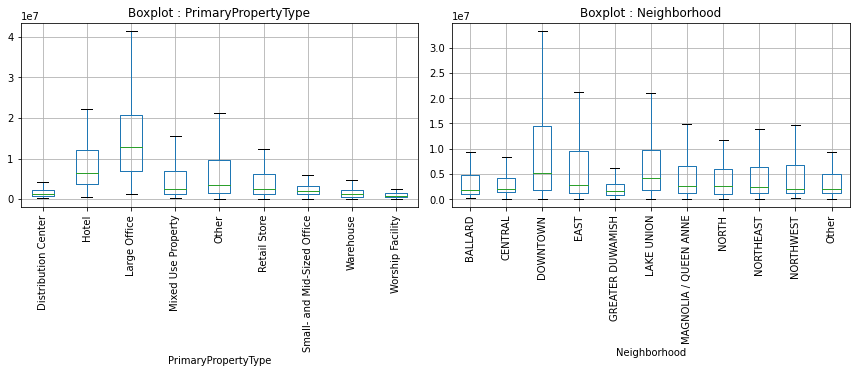

In [ ]:
print_boxplot(df_2016,df_2016.select_dtypes(['object']).columns,'SiteEnergyUse(kBtu)', 2, 2, mes="Boxplot : ", outliers=False)

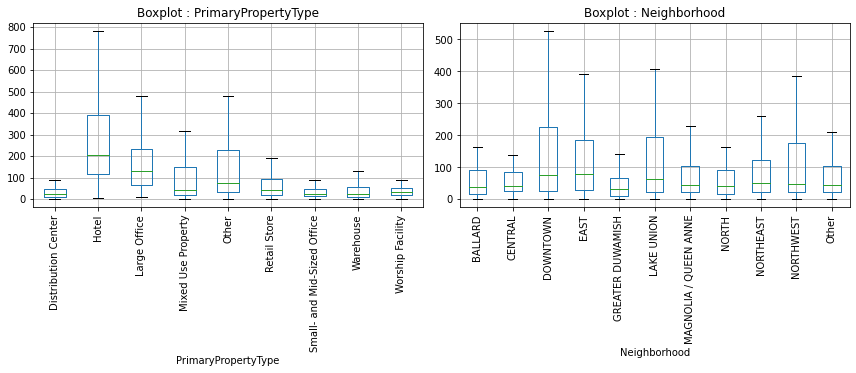

In [ ]:
print_boxplot(df_2016, df_2016.select_dtypes(['object']).columns,'TotalGHGEmissions', 2, 2, mes="Boxplot : ", outliers=False)

Nous pouvons remarquer que les grands bureaux consomment en général le plus d'électricité. Cependant, ceux sont les hôtels qui émettent le plus de gaz à effet de serre.

# Variables cibles

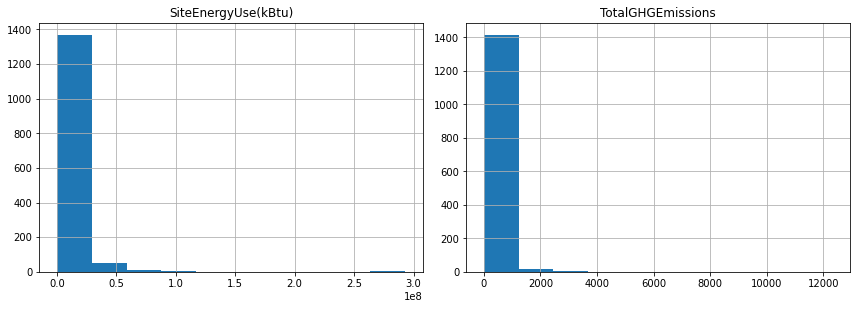

In [ ]:
print_histogram(df_2016, ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], 2, 2)

Dûs à certains types de batîment (hôpitaux, universités, etc.), il y a une présence de valeurs extrêmes.

Afin d'améliorer les modèles prédictifs, notamment ceux linéaires, nous allons faire une transformation logarithmique afin d'avoir une distribution légèrement gaussienne.

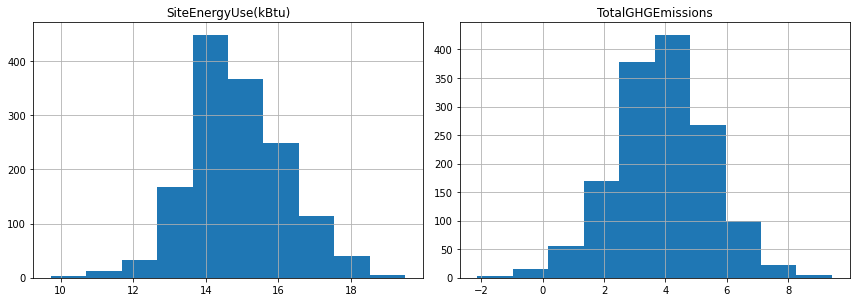

In [ ]:
df_2016[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']] = np.log(df_2016[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']])  
print_histogram(df_2016, ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], 2, 2)

In [ ]:
df_2016.describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1438.000000,984.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,47.616005,-122.333497,3.743150,0.423848,1.114367,2.633707,10.946909,10.832823,63.740854,14.884739,0.710597,0.267964,3.887471
std,0.046608,0.023082,0.862143,0.138536,0.743197,4.216445,0.891170,0.946210,28.870689,1.330568,0.264589,0.264956,1.540040
min,47.509590,-122.411820,0.000000,0.405465,0.405465,0.405465,8.198639,8.640472,1.000000,9.729664,0.000000,0.000000,-2.120264
25%,47.587682,-122.342493,3.332205,0.405465,0.405465,0.405465,10.243996,10.134599,44.000000,13.999226,0.498617,0.000000,2.948771
50%,47.612420,-122.333225,3.931826,0.405465,1.098612,0.405465,10.729635,10.636324,71.000000,14.768404,0.728833,0.215839,3.852273
75%,47.648785,-122.322835,4.465908,0.405465,1.609438,0.405465,11.448571,11.400249,88.250000,15.748053,0.999999,0.481997,4.895935
max,47.733870,-122.261800,4.753590,2.197225,4.595120,13.147267,14.384211,14.334862,100.000000,19.495993,1.000011,1.000000,9.417936


In [ ]:
df_2016_cat = df_2016.copy()
df_2016 = pd.get_dummies(df_2016, columns=df_2016.select_dtypes(['object']).columns, drop_first=True)

# Modèles prédictifs

Pour chaque variable à prédire, nous allons partitionner notre échantillon en 2 nouveaux : un pour l'entraînement (80 %) et un pour le test (20 %).
Nous effectuons également une normalisation étant donné que les données ne sont pas toutes à la même échelle.

In [ ]:
features = [x for x in df_2016.columns if x not in ['Latitude', 'Longitude', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]

X_SEU_train_std, X_SEU_test_std, X_TGE_train_std, X_TGE_test_std, y_SEU_train, \
y_SEU_test, y_TGE_train, y_TGE_test = get_train_test(df_2016, features)

## Baseline

Entraînons une simple régression linéaire comme modèle de base.

In [ ]:
linear_model_SEU = linear_model.LinearRegression().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(linear_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(linear_model_SEU.predict(X_SEU_test_std), y_SEU_test))

linear_model_TGE = linear_model.LinearRegression().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(linear_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(linear_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.46355481615509253
RMSE de test SiteEnergyUse :  0.4721816413783988

RMSE de train pour TotalGHGEmissions:  0.502328845140123
RMSE de test TotalGHGEmissions :  0.516437924532556


## Régressions linéaires

Testons des régressions linéaires avec régularisation

In [ ]:
linear_model_SEU = linear_model.Lasso().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(linear_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(linear_model_SEU.predict(X_SEU_test_std), y_SEU_test))

linear_model_TGE = linear_model.Lasso().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(linear_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(linear_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  1.7950967294562619
RMSE de test SiteEnergyUse :  1.7125720638179514

RMSE de train pour TotalGHGEmissions:  2.391094875018324
RMSE de test TotalGHGEmissions :  2.3232179132804207


Regardons les importances de variables. 

Seules celles des modèles pour la consommation d'énergie seront présentées dans ce notebook étant donné que celles des modèles de l'émission de gaz sont similaires.

In [ ]:
for col, val in zip(features, linear_model_SEU.coef_):
  print(col, val)

YearBuilt -0.0
NumberofBuildings 0.0
NumberofFloors 0.0
PropertyGFAParking 0.0
PropertyGFABuilding(s) 0.0
LargestPropertyUseTypeGFA 0.0
ENERGYSTARScore -0.0
Electricity(kBtu) 0.0
NaturalGas(kBtu) -0.0
PrimaryPropertyType_Hotel 0.0
PrimaryPropertyType_Large Office 0.0
PrimaryPropertyType_Mixed Use Property 0.0
PrimaryPropertyType_Other 0.0
PrimaryPropertyType_Retail Store -0.0
PrimaryPropertyType_Small- and Mid-Sized Office -0.0
PrimaryPropertyType_Warehouse -0.0
PrimaryPropertyType_Worship Facility -0.0
Neighborhood_CENTRAL -0.0
Neighborhood_DOWNTOWN 0.0
Neighborhood_EAST 0.0
Neighborhood_GREATER DUWAMISH -0.0
Neighborhood_LAKE UNION 0.0
Neighborhood_MAGNOLIA / QUEEN ANNE -0.0
Neighborhood_NORTH -0.0
Neighborhood_NORTHEAST -0.0
Neighborhood_NORTHWEST -0.0
Neighborhood_Other -0.0


Nous obtenons de mauvais résultats avec la régularistion Lasso. En affichant les importances des variables, nous pouvons noter que tous les coefficients sont nuls et expliquant donc les prédictions.

In [ ]:
linear_model_SEU = linear_model.Ridge().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(linear_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(linear_model_SEU.predict(X_SEU_test_std), y_SEU_test))

linear_model_TGE = linear_model.Ridge().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(linear_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(linear_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.4635716914023238
RMSE de test SiteEnergyUse :  0.4718457049014189

RMSE de train pour TotalGHGEmissions:  0.5023633261626492
RMSE de test TotalGHGEmissions :  0.5158054445552687


In [ ]:
for col, val in zip(features, linear_model_SEU.coef_):
  print(col, val)

YearBuilt -0.0
NumberofBuildings 0.0
NumberofFloors 0.0
PropertyGFAParking 0.0
PropertyGFABuilding(s) 0.21818091680986246
LargestPropertyUseTypeGFA 0.17709193262314615
ENERGYSTARScore -0.0
Electricity(kBtu) -0.0
NaturalGas(kBtu) 0.0
PrimaryPropertyType_Hotel 0.0
PrimaryPropertyType_Large Office 0.0
PrimaryPropertyType_Mixed Use Property 0.0
PrimaryPropertyType_Other 0.0
PrimaryPropertyType_Retail Store -0.0
PrimaryPropertyType_Small- and Mid-Sized Office -0.0
PrimaryPropertyType_Warehouse -0.0
PrimaryPropertyType_Worship Facility -0.0
Neighborhood_CENTRAL -0.0
Neighborhood_DOWNTOWN 0.0
Neighborhood_EAST 0.0
Neighborhood_GREATER DUWAMISH -0.0
Neighborhood_LAKE UNION 0.0
Neighborhood_MAGNOLIA / QUEEN ANNE -0.0
Neighborhood_NORTH -0.0
Neighborhood_NORTHEAST -0.0
Neighborhood_NORTHWEST -0.0
Neighborhood_Other -0.0


Le modèle avec Ridge emploie que 2 variables : "PropertyGFABuilding" et "LargestPropertyUseTypeGFA"

In [ ]:
linear_model_SEU = linear_model.ElasticNet().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(linear_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(linear_model_SEU.predict(X_SEU_test_std), y_SEU_test))

linear_model_TGE = linear_model.ElasticNet().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(linear_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(linear_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  1.169595273309289
RMSE de test SiteEnergyUse :  1.1074004090075797

RMSE de train pour TotalGHGEmissions:  1.6862430735742084
RMSE de test TotalGHGEmissions :  1.5908175481107232


L'elasticnet perfome mal dues aux mêmes raisons que le modèle Lasso.

Jouons sur la recherche d'hyperparamètre et les validations croisées.

In [ ]:
linear_model_SEU = linear_model.LassoCV().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(linear_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(linear_model_SEU.predict(X_SEU_test_std), y_SEU_test))

linear_model_TGE = linear_model.LassoCV().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(linear_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(linear_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.4639559188334751
RMSE de test SiteEnergyUse :  0.46898399000263136

RMSE de train pour TotalGHGEmissions:  0.5024673280553124
RMSE de test TotalGHGEmissions :  0.5139912516128827


In [ ]:
for col, val in zip(features, linear_model_SEU.coef_):
  print(col, val)

YearBuilt -0.06610118475822785
NumberofBuildings 0.04128244056085521
NumberofFloors 0.026825518321006527
PropertyGFAParking 0.08876167779218423
PropertyGFABuilding(s) 0.5370390877464118
LargestPropertyUseTypeGFA 0.4286925633537444
ENERGYSTARScore -0.3457859199753312
Electricity(kBtu) -0.32733445309
NaturalGas(kBtu) -0.09189711034967321
PrimaryPropertyType_Hotel 0.14827179902778306
PrimaryPropertyType_Large Office 0.28673384115949785
PrimaryPropertyType_Mixed Use Property 0.3100536516526556
PrimaryPropertyType_Other 0.4334631289963005
PrimaryPropertyType_Retail Store 0.1793903978949536
PrimaryPropertyType_Small- and Mid-Sized Office 0.33070452546478313
PrimaryPropertyType_Warehouse -0.01005822439042073
PrimaryPropertyType_Worship Facility 0.010088969865699708
Neighborhood_CENTRAL -0.0335166092777517
Neighborhood_DOWNTOWN 0.06505158812213911
Neighborhood_EAST -0.005398698955207283
Neighborhood_GREATER DUWAMISH 0.044839719997491694
Neighborhood_LAKE UNION 0.08491839122265755
Neighborhood_

Le modèle Lasso optimisé performe nettement mieux que son précédent.

In [ ]:
linear_model_SEU = linear_model.RidgeCV().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(linear_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(linear_model_SEU.predict(X_SEU_test_std), y_SEU_test))

linear_model_TGE = linear_model.RidgeCV().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(linear_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(linear_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.46357169140232474
RMSE de test SiteEnergyUse :  0.47184570490144195

RMSE de train pour TotalGHGEmissions:  0.5023633261626497
RMSE de test TotalGHGEmissions :  0.5158054445553899


In [ ]:
for col, val in zip(features, linear_model_SEU.coef_):
  print(col, val)

YearBuilt -0.0670364595664025
NumberofBuildings 0.043100229248126086
NumberofFloors 0.025597324023280958
PropertyGFAParking 0.08876733631311065
PropertyGFABuilding(s) 0.5319825617151082
LargestPropertyUseTypeGFA 0.43402091937294585
ENERGYSTARScore -0.3487219946179085
Electricity(kBtu) -0.347307964817986
NaturalGas(kBtu) -0.1109396408109182
PrimaryPropertyType_Hotel 0.16259115975616484
PrimaryPropertyType_Large Office 0.3071066905224556
PrimaryPropertyType_Mixed Use Property 0.32875931539820585
PrimaryPropertyType_Other 0.4610414340183319
PrimaryPropertyType_Retail Store 0.19456058249414626
PrimaryPropertyType_Small- and Mid-Sized Office 0.3560809384895888
PrimaryPropertyType_Warehouse 0.0059683908586646
PrimaryPropertyType_Worship Facility 0.02523710624918131
Neighborhood_CENTRAL -0.02755407364121659
Neighborhood_DOWNTOWN 0.0855841027219422
Neighborhood_EAST 0.0038332639546586585
Neighborhood_GREATER DUWAMISH 0.07096553740358415
Neighborhood_LAKE UNION 0.10077269360024252
Neighborhood_

In [ ]:
linear_model_SEU = linear_model.ElasticNetCV().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(linear_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(linear_model_SEU.predict(X_SEU_test_std), y_SEU_test))

linear_model_TGE = linear_model.ElasticNetCV().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(linear_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(linear_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.46391778279300505
RMSE de test SiteEnergyUse :  0.46947852475532603

RMSE de train pour TotalGHGEmissions:  0.5025913149666452
RMSE de test TotalGHGEmissions :  0.5135554024145559


## Réseaux de neurones

Il est possible d'utiliser des réseaux de neurones afin d'employer des modèles non linéaires.

Cependant nous allons d'abord entraîner un modèle à 1 seule couche sans fonction d'activation et donc linéaire.

In [ ]:
model_SEU = tf.keras.Sequential([
    tf.keras.Input(shape=(X_SEU_train.shape[1],)),
    tf.keras.layers.Dense(units=1, 
                          kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1))
])

model_SEU.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mse')

model_SEU.fit(X_SEU_train_std, y_SEU_train, batch_size=16, epochs=100, validation_split=0.2, 
              verbose=0, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

model_TGE = tf.keras.Sequential([
    tf.keras.Input(shape=(X_SEU_train.shape[1],)),
    tf.keras.layers.Dense(units=1, 
                          kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1))
])

model_TGE.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mse')

model_TGE.fit(X_TGE_train_std, y_TGE_train, batch_size=16, epochs=100, validation_split=0.2, 
              verbose=0, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(model_SEU.predict(X_SEU_test_std), y_SEU_test))

print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.4896158134588509
RMSE de test SiteEnergyUse :  0.515779248712607

RMSE de train pour TotalGHGEmissions:  0.7439948649977298
RMSE de test TotalGHGEmissions :  0.8444316574593771


Pour la recherche d'hyperparamètre, un random search est employé en jouant sur :
- Le nombre de neurones par couche
- Le taux de dropout
- La fonction d'activation
- La taux d'apprentissage
- Le nombre d'instance par batch

In [ ]:
random_search_nn(X_SEU_train_std, y_SEU_train, X_SEU_test_std, y_SEU_test, 100)

Itération n° 1
List dense : [(4, 0.15, 'relu'), (16, 0.25, 'linear')], Learning rate : 0.004096794486928234, Batch : 16
Train : 1.2199027761608459, Test : 1.2483696308505976
-----------
Itération n° 2
List dense : [(4, 0.15, 'sigmoid'), (8, 0.2, 'sigmoid')], Learning rate : 0.012426820383308577, Batch : 4
Train : 0.6984721445671404, Test : 0.7663752946028777
-----------
Itération n° 3
List dense : [(8, 0.2, 'linear')], Learning rate : 0.05346931943179986, Batch : 16
Train : 1.5269779984191447, Test : 1.4555076692502227
-----------
Itération n° 4
List dense : [(4, 0.15, 'linear'), (8, 0.2, 'relu')], Learning rate : 0.07378209718447866, Batch : 16
Train : 0.8695592400191651, Test : 0.7641829331429802
-----------
Itération n° 5
List dense : [], Learning rate : 0.001335782816870463, Batch : 16
Train : 74.94397744301732, Test : 74.1550919449545
-----------
Itération n° 6
List dense : [(4, 0.15, 'sigmoid')], Learning rate : 0.001678911048276117, Batch : 16
Train : 1.3366304328544045, Test : 

Le meilleur modèle pour la consommation d'énergie ne possède pas de couche intermédiaire mais est entraîné avec un taux d'apprentissage de 0.0308 et des batchs de 8 instances.

- Le RMSE de train est de 0.4805190380522828
- Le RMSE de test est de 0.47101033655045554

In [ ]:
random_search_nn(X_TGE_train_std, y_TGE_train, X_TGE_test_std, y_TGE_test, 100)

Itération n° 1
List dense : [(16, 0.25, 'relu'), (8, 0.2, 'relu')], Learning rate : 0.004627745678120573, Batch : 8
Train : 0.7447391630321178, Test : 0.7563514225351925
-----------
Itération n° 2
List dense : [(8, 0.2, 'relu'), (8, 0.2, 'relu')], Learning rate : 0.016416907931402304, Batch : 4
Train : 1.0525206650155494, Test : 0.9977521182044187
-----------
Itération n° 3
List dense : [(8, 0.2, 'relu'), (4, 0.15, 'linear')], Learning rate : 0.005712431597126192, Batch : 8
Train : 0.7258878974285203, Test : 0.7418135494382656
-----------
Itération n° 4
List dense : [(8, 0.2, 'sigmoid'), (16, 0.25, 'sigmoid')], Learning rate : 0.006729340997854717, Batch : 4
Train : 0.5361826178880361, Test : 0.63541625376849
-----------
Itération n° 5
List dense : [(4, 0.15, 'relu')], Learning rate : 0.010481775756018748, Batch : 8
Train : 0.5488791121984966, Test : 0.6895517832201942
-----------
Itération n° 6
List dense : [(16, 0.25, 'linear')], Learning rate : 0.03153825156921397, Batch : 8
Train :

Le meilleur modèle pour l'émission de gaz possède 1 couche intermédiaire de 8 neurones sans fonction d'activation et suivie d'un dropout de 0.2. Il est entraîné avec un taux d'apprentissage de 0.00188 et des batchs de 8 instances.

- Le RMSE de train est de 0.5393852131027329
- Le RMSE de test est de 0.5149114295628426

## Modèles ensemblistes

3 types de modèles ensemblistes sont testés : Random Forest, XGBoost et Catboost

### Random Forest

In [ ]:
rand_model_SEU = RandomForestRegressor().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(rand_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(rand_model_SEU.predict(X_SEU_test_std), y_SEU_test))

rand_model_TGE = RandomForestRegressor().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(rand_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(rand_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.07116256997843455
RMSE de test SiteEnergyUse :  0.4709547932742437

RMSE de train pour TotalGHGEmissions:  0.07338416852993784
RMSE de test TotalGHGEmissions :  0.5165301780601371


Un overfit un présent ainsi il est nécessaire de jouer sur le nombre d'arbres, leur profondeur, etc.

In [ ]:
tuning = {
      'max_depth': (3, 5),
      'max_samples': (0.6, 0.9),
      'min_samples_split': (2, 10),             
      'n_estimators': (50, 200),
      'min_samples_leaf': (1, 10)
}

bayes_cv_tuner_SEU = BayesSearchCV(estimator=RandomForestRegressor(bootstrap=True), search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_SEU.fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_test_std), y_SEU_test))
print("Best parameters: {}".format(bayes_cv_tuner_SEU.best_params_))

bayes_cv_tuner_TGE = BayesSearchCV(estimator=RandomForestRegressor(bootstrap=True), search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_TGE.fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_test_std), y_TGE_test))
print("Best parameters: {}".format(bayes_cv_tuner_TGE.best_params_))

RMSE de train pour SiteEnergyUse:  0.43463487267332096
RMSE de test SiteEnergyUse :  0.5377354181403522
Best parameters: OrderedDict([('max_depth', 5), ('max_samples', 0.6), ('min_samples_leaf', 3), ('min_samples_split', 2), ('n_estimators', 200)])

RMSE de train pour TotalGHGEmissions:  0.4538029885807598
RMSE de test TotalGHGEmissions :  0.6019593708753739
Best parameters: OrderedDict([('max_depth', 5), ('max_samples', 0.6), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])


In [ ]:
for col, val in zip(features, bayes_cv_tuner_SEU.best_estimator_.feature_importances_):
  print(col, val)

YearBuilt 0.014112228826758772
NumberofBuildings 0.00014826360055520925
NumberofFloors 0.008152293692167347
PropertyGFAParking 0.013052312353981533
PropertyGFABuilding(s) 0.6023672556422336
LargestPropertyUseTypeGFA 0.17465573480930394
ENERGYSTARScore 0.06703134704464911
Electricity(kBtu) 0.043962907883774105
NaturalGas(kBtu) 0.009698304404883052
PrimaryPropertyType_Hotel 6.320463609305312e-05
PrimaryPropertyType_Large Office 0.0007853600771274048
PrimaryPropertyType_Mixed Use Property 0.0033198867656857242
PrimaryPropertyType_Other 0.01185213303669492
PrimaryPropertyType_Retail Store 2.079817063225377e-05
PrimaryPropertyType_Small- and Mid-Sized Office 0.0008398940829516543
PrimaryPropertyType_Warehouse 0.044248674856101254
PrimaryPropertyType_Worship Facility 0.0006393334395020607
Neighborhood_CENTRAL 0.0
Neighborhood_DOWNTOWN 0.0006186507707177849
Neighborhood_EAST 0.00017915021025375025
Neighborhood_GREATER DUWAMISH 0.0028602308315506656
Neighborhood_LAKE UNION 0.000517459564202337

### XGBoost

In [ ]:
boost_model_SEU = XGBRegressor(objective='reg:squarederror').fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(boost_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(boost_model_SEU.predict(X_SEU_test_std), y_SEU_test))

boost_model_TGE = XGBRegressor(objective='reg:squarederror').fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(boost_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(boost_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.27328626066648304
RMSE de test SiteEnergyUse :  0.41740884123373695

RMSE de train pour TotalGHGEmissions:  0.27174953797376816
RMSE de test TotalGHGEmissions :  0.44503055846243067


Différents paramètres existent pour la régularisation Lasso et Ridge.

La recherche d'hyperparamètre s'effectue avec une optimisation baysienne.

In [ ]:
tuning = {
      'learning_rate': (0.01, 1.0, 'log-uniform'),
      'max_depth': (2, 4),
      'subsample': (0.6, 0.9),
      'min_child_weight': (1, 10),             
      'n_estimators': (50, 200),
      'reg_alpha': (20, 40),
      'reg_lambda': (20, 40),
}

bayes_cv_tuner_SEU = BayesSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_SEU.fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_test_std), y_SEU_test))
print("Best parameters: {}".format(bayes_cv_tuner_SEU.best_params_))

bayes_cv_tuner_TGE = BayesSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_TGE.fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_test_std), y_TGE_test))
print("Best parameters: {}".format(bayes_cv_tuner_TGE.best_params_))

RMSE de train pour SiteEnergyUse:  0.3818256789439305
RMSE de test SiteEnergyUse :  0.45815038069285924
Best parameters: OrderedDict([('learning_rate', 0.183832080110481), ('max_depth', 4), ('min_child_weight', 10), ('n_estimators', 183), ('reg_alpha', 20), ('reg_lambda', 40), ('subsample', 0.9)])

RMSE de train pour TotalGHGEmissions:  0.37890876442447097
RMSE de test TotalGHGEmissions :  0.5017802998705645
Best parameters: OrderedDict([('learning_rate', 0.08185920231239545), ('max_depth', 4), ('min_child_weight', 10), ('n_estimators', 187), ('reg_alpha', 20), ('reg_lambda', 20), ('subsample', 0.9)])


In [ ]:
for col, index in zip(features, ['f'+str(i) for i in range(X_SEU_train.shape[1])]):
  try:
    print(col, bayes_cv_tuner_SEU.best_estimator_.get_booster().get_score(importance_type='gain')[index])
  except KeyError:
    pass

YearBuilt 0.5727765784255452
NumberofFloors 1.657216729240227
PropertyGFAParking 0.46122118274937507
PropertyGFABuilding(s) 7.898028041289998
LargestPropertyUseTypeGFA 5.4105862183358155
ENERGYSTARScore 1.9912470001292117
Electricity(kBtu) 1.09532493786357
NaturalGas(kBtu) 0.45064197649411775
PrimaryPropertyType_Hotel 0.09496886033333334
PrimaryPropertyType_Large Office 0.13240594278333334
PrimaryPropertyType_Mixed Use Property 0.3635823397076923
PrimaryPropertyType_Other 0.28797875198572725
PrimaryPropertyType_Small- and Mid-Sized Office 1.4363737035
PrimaryPropertyType_Warehouse 3.682388761955715
PrimaryPropertyType_Worship Facility 0.6910235592238094
Neighborhood_CENTRAL 0.34958150730909093
Neighborhood_EAST 0.141052182625


### Catboost

Le dataset utilisé pour Catboost est le même que celui utilisé pour les autres modèles sauf que les modalités n'ont pas été transformées en variables binaires.

In [ ]:
features = [x for x in df_2016_cat.columns if x not in ['Latitude', 'Longitude', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]

X_SEU_train, X_SEU_test, X_TGE_train, X_TGE_test, y_SEU_train, y_SEU_test, \
y_TGE_train, y_TGE_test = get_train_test(df_2016_cat, features, catboost_flag=True, index=2)

In [ ]:
cat_model_SEU = CatBoostRegressor(cat_features=[0, 1], verbose=0).fit(X_SEU_train, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(cat_model_SEU.predict(X_SEU_train), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(cat_model_SEU.predict(X_SEU_test), y_SEU_test))

cat_model_TGE = CatBoostRegressor(cat_features=[0, 1], verbose=0).fit(X_TGE_train, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(cat_model_TGE.predict(X_TGE_train), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(cat_model_TGE.predict(X_TGE_test), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.11325381555350553
RMSE de test SiteEnergyUse :  0.40362251366168367

RMSE de train pour TotalGHGEmissions:  0.10842611433737669
RMSE de test TotalGHGEmissions :  0.41873145795898886


In [ ]:
tuning = {
      'learning_rate': (0.01, 1.0, 'log-uniform'),
      'max_depth': (3, 10),
      'subsample': (0.6, 0.9),
      'min_child_samples': (1, 100),             
      'n_estimators': (50, 100),
      'bagging_temperature':(0.3, 1.0),
      'l2_leaf_reg':(1000, 2000),
      'random_strength':(0.1, 0.7)
}

bayes_cv_tuner_SEU = BayesSearchCV(estimator=CatBoostRegressor(cat_features=[0, 1], verbose=0), 
                                   search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_SEU.fit(X_SEU_train, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_train), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_test), y_SEU_test))
print("Best parameters: {}".format(bayes_cv_tuner_SEU.best_params_))

bayes_cv_tuner_TGE = BayesSearchCV(estimator=CatBoostRegressor(cat_features=[0, 1], verbose=0), 
                                   search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_TGE.fit(X_TGE_train, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_train), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_test), y_TGE_test))
print("Best parameters: {}".format(bayes_cv_tuner_TGE.best_params_))

RMSE de train pour SiteEnergyUse:  0.43376997606397344
RMSE de test SiteEnergyUse :  0.46815710033309416
Best parameters: OrderedDict([('bagging_temperature', 1.0), ('l2_leaf_reg', 1000), ('learning_rate', 1.0), ('max_depth', 3), ('min_child_samples', 1), ('n_estimators', 100), ('random_strength', 0.7), ('subsample', 0.6)])

RMSE de train pour TotalGHGEmissions:  0.4678805510871707
RMSE de test TotalGHGEmissions :  0.509528964934987
Best parameters: OrderedDict([('bagging_temperature', 0.3), ('l2_leaf_reg', 1000), ('learning_rate', 1.0), ('max_depth', 3), ('min_child_samples', 100), ('n_estimators', 100), ('random_strength', 0.7), ('subsample', 0.6)])


In [ ]:
for col, val in zip(features, bayes_cv_tuner_SEU.best_estimator_.get_feature_importance()):
  print(col, val)

PrimaryPropertyType 14.35882536189523
Neighborhood 0.0
YearBuilt 2.5634462041773856
NumberofBuildings 0.0002800354652550811
NumberofFloors 4.432445293274598
PropertyGFAParking 1.259680139786042
PropertyGFABuilding(s) 28.420589572600978
LargestPropertyUseTypeGFA 30.19599923017473
ENERGYSTARScore 10.605932523169404
Electricity(kBtu) 7.012117890708304
NaturalGas(kBtu) 1.1506837487480626


Contrairement aux autres modèles qui se basaient essentiellement sur "PropertyGFAParking" et "LargestPropertyUseTypeGFA", Catboost prend beaucoup en considération "PrimaryPropertyType". Cependant, la localisation est ignorée.

Ré-entraînons un autre modèle Catboost en laissant toutes les modalités des variables qualitatives.

In [ ]:
features = [x for x in df_2016_cat.columns if x not in ['Latitude', 'Longitude', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]
df_2016_cat[df_2016_mod.columns] = df_2016_mod
X_SEU_train, X_SEU_test, X_TGE_train, X_TGE_test, y_SEU_train, y_SEU_test, \
y_TGE_train, y_TGE_test = get_train_test(df_2016_cat, features, catboost_flag=True, index=2)

In [ ]:
tuning = {
      'learning_rate': (0.01, 1.0, 'log-uniform'),
      'max_depth': (3, 10),
      'subsample': (0.6, 0.9),
      'min_child_samples': (1, 100),             
      'n_estimators': (50, 200),
      'bagging_temperature':(0.3, 1.0),
      'l2_leaf_reg':(1000, 2000),
      'random_strength':(0.1, 0.7)
}

bayes_cv_tuner_SEU = BayesSearchCV(estimator=CatBoostRegressor(cat_features=[0, 1], verbose=0), 
                                   search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_SEU.fit(X_SEU_train, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_train), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_test), y_SEU_test))
print("Best parameters: {}".format(bayes_cv_tuner_SEU.best_params_))

bayes_cv_tuner_TGE = BayesSearchCV(estimator=CatBoostRegressor(cat_features=[0, 1], verbose=0), 
                                   search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_TGE.fit(X_TGE_train, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_train), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_test), y_TGE_test))
print("Best parameters: {}".format(bayes_cv_tuner_TGE.best_params_))

RMSE de train pour SiteEnergyUse:  0.3424164936147326
RMSE de test SiteEnergyUse :  0.39812717600159747
Best parameters: OrderedDict([('bagging_temperature', 1.0), ('l2_leaf_reg', 1000), ('learning_rate', 1.0), ('max_depth', 3), ('min_child_samples', 82), ('n_estimators', 200), ('random_strength', 0.5316787665066787), ('subsample', 0.6)])

RMSE de train pour TotalGHGEmissions:  0.36009722868585653
RMSE de test TotalGHGEmissions :  0.4431223089898287
Best parameters: OrderedDict([('bagging_temperature', 1.0), ('l2_leaf_reg', 1000), ('learning_rate', 1.0), ('max_depth', 3), ('min_child_samples', 1), ('n_estimators', 200), ('random_strength', 0.1), ('subsample', 0.6)])


In [ ]:
for col, val in zip(features, bayes_cv_tuner_SEU.best_estimator_.get_feature_importance()):
  print(col, val)

PrimaryPropertyType 24.45760531007454
Neighborhood 0.6352025765371112
YearBuilt 3.0695540250365116
NumberofBuildings 0.0014975881163490573
NumberofFloors 2.8260071109050635
PropertyGFAParking 0.9304533286500306
PropertyGFABuilding(s) 24.290607634918135
LargestPropertyUseTypeGFA 23.948414204384488
ENERGYSTARScore 11.761317625451989
Electricity(kBtu) 7.699601052450354
NaturalGas(kBtu) 0.379739543475402


Les prédictions sont améliorées et "PrimaryPropertyType" est nettement plus pris en compte.

### GMM

Au lieu d'utiliser les modalités de la variable quartiers pour la location, nous pouvons utiliser les prédictions d'un modèle Gaussian Mixture Model. Ce dernier effectue du clustering en attribuant une probabilité d'appartenance à chaque groupe.

Pour cela, nous utilisons la latitude et la longitude.

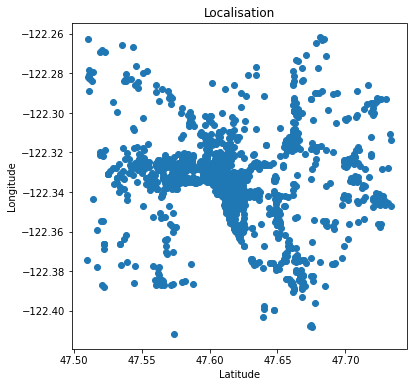

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(df_2016["Latitude"],df_2016["Longitude"])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Localisation')
plt.show()

Prenons un exemple.

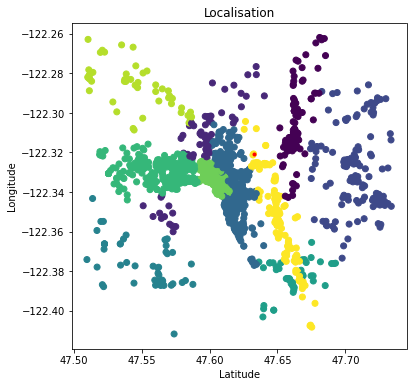

In [ ]:
n_class = 10 
gmm = GaussianMixture(n_components=n_class)
gmm.fit(df_2016[['Latitude', 'Longitude']])
labels = gmm.predict(df_2016[['Latitude', 'Longitude']])

i = 800
plt.figure(figsize=(6,6))
plt.scatter(df_2016["Latitude"],df_2016["Longitude"], c=labels)
plt.plot([df_2016["Latitude"].iloc[i]], [df_2016["Longitude"].iloc[i]], marker='o', markersize=3, color="red")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Localisation')
plt.show()

Le point rouge est attribué à la classe en jaune. Cependant il est également proche d'autres classes.

In [ ]:
gmm.predict_proba([df_2016[['Latitude', 'Longitude']].iloc[i]])

array([[8.86041880e-06, 1.63940658e-03, 1.83628847e-05, 6.42191186e-02,
        8.76704716e-14, 1.51088388e-13, 1.73905430e-03, 3.04002678e-13,
        7.30542445e-03, 9.25069773e-01]])

En regardant les probabalités d'appartenance, nous notons qu'il fait majoritairement partie de la dernière classe mais également de la 4ème classe avec une plus faible probabilité. La première classe possède une valeur plus faible comme elle est sûrement plus éloignée. 

In [ ]:
classes = ['classe' + str(i) for i in range(n_class)]
df_2016_gmm = df_2016_cat.copy()
df_2016_gmm[classes] = gmm.predict_proba(df_2016[['Latitude', 'Longitude']])

In [ ]:
features = [x for x in df_2016_gmm.columns if x not in ['Neighborhood', 'Latitude', 'Longitude', 
                                                        'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]

X_SEU_train, X_SEU_test, X_TGE_train, X_TGE_test, y_SEU_train, y_SEU_test,\
y_TGE_train, y_TGE_test = get_train_test(df_2016_gmm, features, catboost_flag=True, index=1)

In [ ]:
tuning = {
      'learning_rate': (0.01, 1.0, 'log-uniform'),
      'max_depth': (3, 10),
      'subsample': (0.6, 0.9),
      'min_child_samples': (1, 100),             
      'n_estimators': (50, 100),
      'bagging_temperature':(0.3, 1.0),
      'l2_leaf_reg':(1000, 2000),
      'random_strength':(0.1, 0.7)
}

bayes_cv_tuner_SEU = BayesSearchCV(estimator=CatBoostRegressor(cat_features=[0], verbose=0), 
                                   search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_SEU.fit(X_SEU_train, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_train), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_test), y_SEU_test))
print("Best parameters: {}".format(bayes_cv_tuner_SEU.best_params_))

bayes_cv_tuner_TGE = BayesSearchCV(estimator=CatBoostRegressor(cat_features=[0], verbose=0), 
                                   search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_TGE.fit(X_TGE_train, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_train), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_test), y_TGE_test))
print("Best parameters: {}".format(bayes_cv_tuner_TGE.best_params_))

RMSE de train pour SiteEnergyUse:  0.38564382607030184
RMSE de test SiteEnergyUse :  0.4404048880383763
Best parameters: OrderedDict([('bagging_temperature', 1.0), ('l2_leaf_reg', 1000), ('learning_rate', 1.0), ('max_depth', 3), ('min_child_samples', 1), ('n_estimators', 100), ('random_strength', 0.1), ('subsample', 0.6)])

RMSE de train pour TotalGHGEmissions:  0.4875880679515882
RMSE de test TotalGHGEmissions :  0.5755986016420322
Best parameters: OrderedDict([('bagging_temperature', 0.3), ('l2_leaf_reg', 1000), ('learning_rate', 1.0), ('max_depth', 4), ('min_child_samples', 1), ('n_estimators', 100), ('random_strength', 0.1), ('subsample', 0.9)])


In [ ]:
for col, val in zip(features, bayes_cv_tuner_SEU.best_estimator_.get_feature_importance()):
  print(col, val)

PrimaryPropertyType 20.87621689771527
YearBuilt 2.2085252518643403
NumberofBuildings 0.0006658871385269315
NumberofFloors 2.110627242430782
PropertyGFAParking 0.47773014335986363
PropertyGFABuilding(s) 37.06476594202622
LargestPropertyUseTypeGFA 18.70219258150079
ENERGYSTARScore 9.517056836086981
Electricity(kBtu) 4.196444328403003
NaturalGas(kBtu) 0.9617106732020485
classe0 0.016567345271628647
classe1 0.5040095137750737
classe2 0.0018210620161755611
classe3 0.08219047358135903
classe4 2.274049330587455
classe5 0.01921608865043668
classe6 0.1853574103222576
classe7 0.5750616798740729
classe8 0.20600456496926164
classe9 0.019786747224491363


Les prédictions ne sont pas meilleures que le modèle Catboost précédent. Cela est normale étant donné que la localition n'apporte pas beaucoup d'informations pour les prédictions. Cependant, ce modèle prend un peu plus en compte la localisation.

Testons sur les autres types de modèles.

In [ ]:
df_2016_gmm = df_2016_gmm.drop(["Neighborhood", "Latitude", "Longitude"], axis=1)
df_2016_gmm = pd.get_dummies(df_2016_gmm, columns=["PrimaryPropertyType"], drop_first=True)
features = [x for x in df_2016_gmm.columns if x not in ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]
X_SEU_train_std, X_SEU_test_std, X_TGE_train_std, X_TGE_test_std = get_train_test(df_2016_gmm, features)

In [ ]:
linear_model_SEU = linear_model.Ridge().fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(linear_model_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(linear_model_SEU.predict(X_SEU_test_std), y_SEU_test))

linear_model_TGE = linear_model.Ridge().fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(linear_model_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(linear_model_TGE.predict(X_TGE_test_std), y_TGE_test))

RMSE de train pour SiteEnergyUse:  0.4666946112349231
RMSE de test SiteEnergyUse :  0.45510522573488327

RMSE de train pour TotalGHGEmissions:  0.5059675585026395
RMSE de test TotalGHGEmissions :  0.49959089671309936


In [ ]:
tuning = {
      'learning_rate': (0.01, 1.0, 'log-uniform'),
      'max_depth': (2, 4),
      'subsample': (0.6, 0.9),
      'min_child_weight': (1, 10),             
      'n_estimators': (50, 200),
      'reg_alpha': (20, 40),
      'reg_lambda': (20, 40),
}

bayes_cv_tuner_SEU = BayesSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_SEU.fit(X_SEU_train_std, y_SEU_train)
print("RMSE de train pour SiteEnergyUse: ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_train_std), y_SEU_train))
print("RMSE de test SiteEnergyUse : ", mean_squared_error(bayes_cv_tuner_SEU.predict(X_SEU_test_std), y_SEU_test))
print("Best parameters: {}".format(bayes_cv_tuner_SEU.best_params_))

bayes_cv_tuner_TGE = BayesSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), search_spaces=tuning, cv=5, n_jobs=2, n_iter=100)
bayes_cv_tuner_TGE.fit(X_TGE_train_std, y_TGE_train)
print("\nRMSE de train pour TotalGHGEmissions: ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_train_std), y_TGE_train))
print("RMSE de test TotalGHGEmissions : ", mean_squared_error(bayes_cv_tuner_TGE.predict(X_TGE_test_std), y_TGE_test))
print("Best parameters: {}".format(bayes_cv_tuner_TGE.best_params_))

RMSE de train pour SiteEnergyUse:  0.35192066755355517
RMSE de test SiteEnergyUse :  0.4668725228269372
Best parameters: OrderedDict([('learning_rate', 0.19599969237291204), ('max_depth', 4), ('min_child_weight', 10), ('n_estimators', 200), ('reg_alpha', 20), ('reg_lambda', 20), ('subsample', 0.9)])

RMSE de train pour TotalGHGEmissions:  0.3467503351570925
RMSE de test TotalGHGEmissions :  0.5312055257384133
Best parameters: OrderedDict([('learning_rate', 0.26150155166536593), ('max_depth', 4), ('min_child_weight', 10), ('n_estimators', 169), ('reg_alpha', 20), ('reg_lambda', 20), ('subsample', 0.6)])


In [ ]:
for col, index in zip(features, ['f'+str(i) for i in range(X_SEU_train.shape[1])]):
  try:
    print(col, bayes_cv_tuner_SEU.best_estimator_.get_booster().get_score(importance_type='gain')[index])
  except KeyError:
    pass

YearBuilt 0.9423638065909756
NumberofFloors 0.5469522280400001
PropertyGFAParking 0.4970581028564445
PropertyGFABuilding(s) 12.136004427205183
LargestPropertyUseTypeGFA 3.792339450505628
ENERGYSTARScore 1.958828948712
Electricity(kBtu) 1.5065782084641302
NaturalGas(kBtu) 0.40891712923875
classe0 0.52648437234185
classe1 0.29649566056000004
classe2 0.626858558827925
classe3 0.29405686771375167
classe4 0.8137683993275906
classe5 0.8482603251999998
classe6 0.42601529628568136
classe7 0.7424386361749999
classe8 0.9458286706
classe9 0.8657028320923336
PrimaryPropertyType_Hotel 0.176801808


Les prédictions sont légèrement meilleurs sur la régression linéaire Rigde mais pas pour le XGBoost.

## Analyse d'erreurs

Effectuons une analyse d'erreurs sur les prédictions en récupérans le meilleur modèle de Catboost.

In [ ]:
model_SEU = bayes_cv_tuner_SEU.best_estimator_
model_TGE = bayes_cv_tuner_TGE.best_estimator_
pred_train_SEU = model_SEU.predict(X_SEU_train)
pred_test_SEU = model_SEU.predict(X_SEU_test)
pred_train_TGE = model_TGE.predict(X_TGE_train)
pred_test_TGE = model_TGE.predict(X_TGE_test)

### Energie

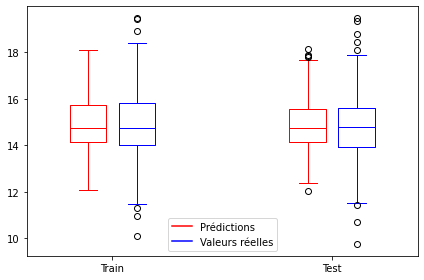

In [ ]:
fig, ax = plt.subplots()

box_pred = ax.boxplot([pred_train_SEU, pred_test_SEU], positions=[0, 1.8], 
                       widths=0.3)
box_y = ax.boxplot([df_2016_cat["SiteEnergyUse(kBtu)"][X_SEU_train.index],
                    df_2016_cat["SiteEnergyUse(kBtu)"][X_SEU_test.index]], 
                    positions=[0.4, 2.2], widths=0.3)

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box_pred[item], color="red")
        plt.setp(box_y[item], color="blue")

ax.plot([], c='red', label='Prédictions')
ax.plot([], c='blue', label='Valeurs réelles')
ax.legend()

plt.xticks([0.2, 2], ["Train", "Test"])
plt.tight_layout()

plt.show()

Nous observons que les prédictions possèdent la même distribution que les valeurs réelles avec une moyenne et quantiles assez similairs.

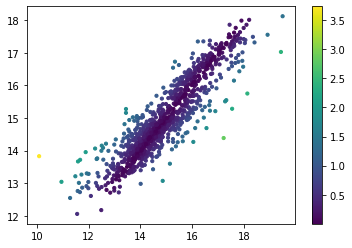

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
1045,Retail Store,GREATER DUWAMISH,47.56535,-122.34054,4.143135,0.405465,0.405465,0.405465,10.594132,10.126631,100.0,11.887717,0.336876,0.663125,1.697449
1229,Small- and Mid-Sized Office,DOWNTOWN,47.61119,-122.33581,4.727388,0.405465,1.098612,0.405465,10.963359,10.126631,NaN,10.090195,0.999979,0.000000,-1.771957
3203,Other,DOWNTOWN,47.61449,-122.33956,3.713572,0.405465,1.945910,10.466526,10.925201,11.002100,100.0,17.545547,1.000000,0.000000,5.671845
240,Other,NORTHEAST,47.66060,-122.31512,3.850148,0.405465,1.609438,0.405465,10.491274,10.491274,96.0,17.217990,1.000000,0.000000,5.344294
1027,Other,Other,47.56979,-122.29234,3.970292,0.405465,0.693147,0.405465,9.905835,9.905835,NaN,11.673669,0.999997,0.000000,-0.198451
309,Mixed Use Property,LAKE UNION,47.61915,-122.34857,2.708050,0.405465,1.791759,11.560972,11.598295,11.560972,100.0,18.133983,0.997915,0.002085,6.273990
2450,Other,EAST,47.61427,-122.31977,4.663439,0.405465,1.098612,0.405465,10.376611,9.971146,NaN,11.591740,0.105083,0.894914,1.652497
558,Other,DOWNTOWN,47.61438,-122.33871,3.555348,0.405465,3.496508,0.405465,12.970156,12.296813,98.0,19.431125,0.999455,0.000545,7.561028
1577,Other,MAGNOLIA / QUEEN ANNE,47.64418,-122.37587,4.615121,0.405465,1.098612,0.405465,10.595434,10.595434,NaN,10.953141,0.999997,0.000000,-0.916291


In [ ]:
diff = abs(df_2016_cat["SiteEnergyUse(kBtu)"][X_SEU_train.index] - pred_train_SEU)
plt.scatter(df_2016_cat["SiteEnergyUse(kBtu)"][X_SEU_train.index], pred_train_SEU, s=10, c=diff)
plt.colorbar()
plt.show()
df_2016_cat.loc[diff[diff > 2].index]

L'abscisse représente les valeurs réelles et l'ordonnée les prédictions.

Plus la couleur est claire, plus la prédiction est éloignée de la valeur réelle.

La table représente les instances avec des prédictions éloignées.

In [ ]:
df_2016_cat.loc[X_SEU_train.index].describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1006.000000,692.000000,1009.000000,1009.000000,1009.000000,1009.000000
mean,47.616142,-122.333843,3.729995,0.421176,1.124059,2.761043,10.954365,10.839489,62.628613,14.918391,0.713089,0.264322,3.912632
std,0.046502,0.023161,0.859178,0.121418,0.759690,4.290534,0.906583,0.956144,29.136724,1.340477,0.265135,0.265176,1.547083
min,47.509590,-122.411820,0.000000,0.405465,0.405465,0.405465,8.198639,8.640472,1.000000,10.090195,0.087370,0.000000,-1.771957
25%,47.588010,-122.342740,3.332205,0.405465,0.405465,0.405465,10.237564,10.147511,43.000000,14.014152,0.495058,0.000000,2.980111
50%,47.612560,-122.333270,3.912023,0.405465,1.098612,0.405465,10.729854,10.633700,69.000000,14.767409,0.730487,0.199383,3.886910
75%,47.649010,-122.323770,4.454347,0.405465,1.609438,0.405465,11.458607,11.407565,87.000000,15.808291,0.999999,0.485594,4.924787
max,47.733680,-122.261800,4.753590,2.197225,4.595120,12.918520,14.305819,14.334862,100.000000,19.495993,1.000003,0.912630,9.281225


In [ ]:
df_2016_cat.loc[diff[diff > 2].index].describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
count,9.000000,9.000000,9.000000,9.000000e+00,9.000000,9.000000,9.000000,9.000000,5.000000,9.000000,9.000000,9.000000,9.000000
mean,47.612600,-122.334032,3.994055,4.054651e-01,1.470896,2.762862,10.935589,10.675204,98.800000,14.280568,0.826589,0.173408,2.812712
std,0.030457,0.023343,0.646144,1.177569e-16,0.908757,4.685809,0.893174,0.810150,1.788854,3.692019,0.348205,0.348206,3.458543
min,47.565350,-122.375870,2.708050,4.054651e-01,0.405465,0.405465,9.905835,9.905835,96.000000,10.090195,0.105083,0.000000,-1.771957
25%,47.611190,-122.340540,3.713572,4.054651e-01,1.098612,0.405465,10.491274,10.126631,98.000000,11.591740,0.997915,0.000000,-0.198451
50%,47.614380,-122.338710,3.970292,4.054651e-01,1.098612,0.405465,10.595434,10.491274,100.000000,11.887717,0.999979,0.000000,1.697449
75%,47.619150,-122.319770,4.615121,4.054651e-01,1.791759,0.405465,10.963359,11.002100,100.000000,17.545547,0.999997,0.002085,5.671845
max,47.660600,-122.292340,4.727388,4.054651e-01,3.496508,11.560972,12.970156,12.296813,100.000000,19.431125,1.000000,0.894914,7.561028


En comparant les distributions de valeurs du datasat d'entraînement et celles des instances avec une mauvaise prédiction, nous n'observons pas de grandes différences et donc nous ne pouvons expliquer ces mauvais résultats.

Nous pouvons juste noter que ces instances ont plutôt des valeurs extrêmes pour la variable cible.

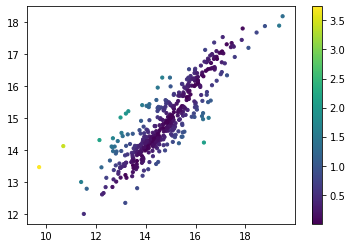

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
768,Other,DOWNTOWN,47.61741,-122.33491,3.178054,0.405465,0.693147,0.405465,10.272392,10.268131,NaN,12.992965,0.397822,0.602178,2.725890
1295,Other,DOWNTOWN,47.60711,-122.33886,4.753590,0.405465,1.098612,0.405465,10.814967,10.086600,NaN,10.698593,1.000011,0.000000,-1.171183
2189,Other,GREATER DUWAMISH,47.58788,-122.33458,4.663439,0.405465,1.098612,0.405465,10.228827,10.115247,NaN,9.729664,1.000006,0.000000,-2.120264
2222,Retail Store,Other,47.54723,-122.28455,3.912023,0.405465,0.405465,0.405465,10.542258,10.265836,88.0,16.335993,0.431054,0.568946,6.023690
2411,Other,DOWNTOWN,47.59976,-122.33514,4.753590,0.405465,1.098612,0.405465,10.007848,10.007848,NaN,12.148156,0.341481,0.658521,1.953028


In [ ]:
diff = abs(df_2016_cat["SiteEnergyUse(kBtu)"][X_SEU_test.index]-pred_test_SEU)
plt.scatter(df_2016_cat["SiteEnergyUse(kBtu)"][X_SEU_test.index], pred_test_SEU, s=10, c=diff)
plt.colorbar()
plt.show()
df_2016_cat.loc[diff[diff > 2].index]

Nous observons une mauvaise prédiction dans le dataset test pour les valeurs faibles.

### Emission GHG

Analysons les erreurs pour la variable cible d'émissions de gaz à effet de serre.

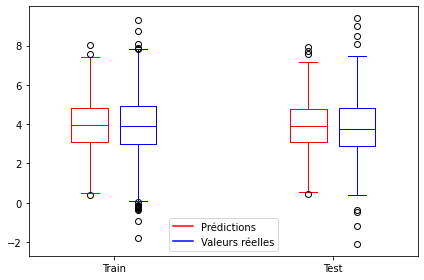

In [ ]:
fig, ax = plt.subplots()

box_pred = ax.boxplot([pred_train_TGE, pred_test_TGE], positions=[0, 1.8], 
                       widths=0.3)
box_y = ax.boxplot([df_2016_cat["TotalGHGEmissions"][X_TGE_train.index],
                    df_2016_cat["TotalGHGEmissions"][X_TGE_test.index]], 
                    positions=[0.4, 2.2], widths=0.3)

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box_pred[item], color="red")
        plt.setp(box_y[item], color="blue")

ax.plot([], c='red', label='Prédictions')
ax.plot([], c='blue', label='Valeurs réelles')
ax.legend()

plt.xticks([0.2, 2], ["Train", "Test"])
plt.tight_layout()

plt.show()

Les distributions semblent similaires.

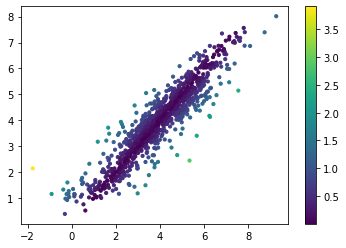

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
2380,Mixed Use Property,LAKE UNION,47.62774,-122.33384,3.332205,0.405465,0.693147,9.642253,9.864591,10.059337,NaN,16.555103,0.429073,0.570927,6.245545
1229,Small- and Mid-Sized Office,DOWNTOWN,47.61119,-122.33581,4.727388,0.405465,1.098612,0.405465,10.963359,10.126631,NaN,10.090195,0.999979,0.000000,-1.771957
3203,Other,DOWNTOWN,47.61449,-122.33956,3.713572,0.405465,1.945910,10.466526,10.925201,11.002100,100.0,17.545547,1.000000,0.000000,5.671845
240,Other,NORTHEAST,47.66060,-122.31512,3.850148,0.405465,1.609438,0.405465,10.491274,10.491274,96.0,17.217990,1.000000,0.000000,5.344294
3063,Other,GREATER DUWAMISH,47.56268,-122.32364,3.828641,0.405465,0.405465,0.405465,10.038455,10.679412,NaN,16.118674,0.891685,0.108314,4.785490
309,Mixed Use Property,LAKE UNION,47.61915,-122.34857,2.708050,0.405465,1.791759,11.560972,11.598295,11.560972,100.0,18.133983,0.997915,0.002085,6.273990
2450,Other,EAST,47.61427,-122.31977,4.663439,0.405465,1.098612,0.405465,10.376611,9.971146,NaN,11.591740,0.105083,0.894914,1.652497
558,Other,DOWNTOWN,47.61438,-122.33871,3.555348,0.405465,3.496508,0.405465,12.970156,12.296813,98.0,19.431125,0.999455,0.000545,7.561028
1577,Other,MAGNOLIA / QUEEN ANNE,47.64418,-122.37587,4.615121,0.405465,1.098612,0.405465,10.595434,10.595434,NaN,10.953141,0.999997,0.000000,-0.916291


In [ ]:
diff = abs(df_2016_cat["TotalGHGEmissions"][X_TGE_train.index] - pred_train_TGE)
plt.scatter(df_2016_cat["TotalGHGEmissions"][X_TGE_train.index], pred_train_TGE, s=10, c=diff)
plt.colorbar()
plt.show()
df_2016_cat.loc[diff[diff > 2].index]

Tout comme pour l'autre varible explicative, il est assez d'expliquer ces mauvaises prédictions.

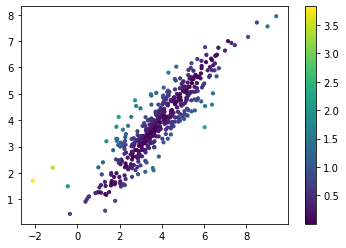

,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
768,Other,DOWNTOWN,47.61741,-122.33491,3.178054,0.405465,0.693147,0.405465,10.272392,10.268131,NaN,12.992965,0.397822,0.602178,2.725890
1295,Other,DOWNTOWN,47.60711,-122.33886,4.753590,0.405465,1.098612,0.405465,10.814967,10.086600,NaN,10.698593,1.000011,0.000000,-1.171183
2189,Other,GREATER DUWAMISH,47.58788,-122.33458,4.663439,0.405465,1.098612,0.405465,10.228827,10.115247,NaN,9.729664,1.000006,0.000000,-2.120264
2222,Retail Store,Other,47.54723,-122.28455,3.912023,0.405465,0.405465,0.405465,10.542258,10.265836,88.0,16.335993,0.431054,0.568946,6.023690
2411,Other,DOWNTOWN,47.59976,-122.33514,4.753590,0.405465,1.098612,0.405465,10.007848,10.007848,NaN,12.148156,0.341481,0.658521,1.953028


In [ ]:
diff = abs(df_2016_cat["TotalGHGEmissions"][X_TGE_test.index]-pred_test_TGE)
plt.scatter(df_2016_cat["TotalGHGEmissions"][X_TGE_test.index], pred_test_TGE, s=10, c=diff)
plt.colorbar()
plt.show()
df_2016_cat.loc[diff[diff > 2].index]

Ce que nous pouvons retenir est que l'ensemble des prédictions sont proches des valeurs réelles notamment pour les valeurs les plus réprésentées.

# Conclusion

Les modèles linéaires performent bien sûrement due à la distribution normale des variables cibles et des corrélations assez linéaires avec les variables prédictifs.

Catboost est intéressant à employer grâce à la présence de variables qualitatives.

En ayant plus de données, nous aurions sûrement pu améliorer nos modèles notamment les réseaux de neurones.

Les points d'amélioration :
- Jouer encore plus sur les paramètres lors du tuning
- Mieux traiter les valeurs manquantes (la moyenne est actuellement utilisée)
- Tester d'autres transformations de variables (ici seul le log et la standadisation sont employés)
- Effectuer une analyse d'erreur plus affrondie